## Практическая работа к занятию №3

1. Постройте нейронную сеть(берем простую линейную сеть, которую разбирали на уроке: меняем число слоев, число нейронов , типы активации, тип оптимизатора)  на датасет from sklearn.datasets import load_boston. 
2. Измените функцию потерь и метрику для этой задачи. Постройте 10-15 вариантов и сведите результаты их работы в таблицу  Опишите, какого результата вы добились от нейросети? Что помогло вам улучшить ее точность?

Датасет load_boston является устаревшим и содержит определенные проблемы в данных, указанные в документации sklearn. По рекомендациям sklearn взял аналогичный датасет fetch_california_housing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [2]:
!nvidia-smi

Tue Feb 15 22:03:24 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
tf.config.experimental.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Подготовка данных

In [4]:
X_data, y_data = fetch_california_housing(return_X_y=True, as_frame=True)

In [5]:
X_data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [6]:
y_data.head()

0    4.526
1    3.585
2    3.521
3    3.413
4    3.422
Name: MedHouseVal, dtype: float64

In [7]:
X_data, y_data = fetch_california_housing(return_X_y=True, as_frame=False)

In [8]:
print(X_data.shape, y_data.shape)

(20640, 8) (20640,)


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data,
                                                    test_size=0.3,
                                                    random_state=42)

### Архитектура модели

In [10]:
def create_model(activation):
    normalizer = tf.keras.layers.Normalization()
    normalizer.adapt(X_train)

    model = keras.Sequential([
        normalizer,             
        keras.layers.Dense(1024, activation=activation, 
                           input_shape=(X_train.shape[1],)),
        keras.layers.Dense(512, activation=activation),
        keras.layers.Dense(512, activation=activation),
        keras.layers.Dense(512, activation=activation),
        keras.layers.Dense(1, activation=activation)
    ])

    return model

def get_model(activation, optimizer, loss):
    model = create_model(activation)
    model.load_weights(f"{activation}.h5")

    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=[tf.keras.metrics.MeanAbsoluteError(),
                           tf.keras.metrics.MeanSquaredError()])

    return model

Инициализируем 2 модели с разными функциями активациями: linear и ReLU. Сохраним их веса, чтобы в дальнейшем при переборе других параметров, подгружать одинаковые стартовые веса

In [11]:
model = create_model('linear')
model.save_weights('linear.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 8)                17        
 n)                                                              
                                                                 
 dense (Dense)               (None, 1024)              9216      
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 dense_3 (Dense)             (None, 512)               262656    
                                                                 
 dense_4 (Dense)             (None, 1)                 513       
                                                        

In [12]:
model = create_model('relu')
model.save_weights('relu.h5')

### Обучение моделей

In [13]:
def train_model(model, epochs=50, batch_size=2048):
    train_history = model.fit( 
        X_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.2,
        verbose=0
    )
    train_logs = model.evaluate(
        X_train,
        y_train,
        verbose=0
    )
    test_logs = model.evaluate(
        X_test,
        y_test,
        verbose=0
    )
    return train_history, train_logs, test_logs

In [14]:
loss_grid = ['mse', 'mae']

optimizer_grid = ['Adam', 'SGD', 'RMSProp', 'Adagrad']

activation_grid = ['relu', 'linear']

In [15]:
results = {}

for activation in activation_grid:
    for loss in loss_grid:
        for optimizer in optimizer_grid:
            print(f"{activation}_{optimizer}_{loss}")
            model = get_model(activation, optimizer, loss)
            train_history, train_logs, test_logs = train_model(model)
            results[f"{activation}_{optimizer}_{loss}"] = {
                'train_history': train_history.history,
                'train_mae': train_logs[1],
                'train_mse': train_logs[2],
                'test_mae': test_logs[1],
                'test_mse': test_logs[2]
            }

relu_Adam_mse
relu_SGD_mse
relu_RMSProp_mse
relu_Adagrad_mse
relu_Adam_mae
relu_SGD_mae
relu_RMSProp_mae
relu_Adagrad_mae
linear_Adam_mse
linear_SGD_mse
linear_RMSProp_mse
linear_Adagrad_mse
linear_Adam_mae
linear_SGD_mae
linear_RMSProp_mae
linear_Adagrad_mae


### Анализ результатов

In [16]:
df = pd.DataFrame.from_dict(results, orient='index',
                            columns=['train_mae', 'train_mse', 'test_mae', 'test_mse'])
df.sort_values(by='test_mse', ascending=True, inplace=True)
df

,train_mae,train_mse,test_mae,test_mse
relu_Adam_mae,0.318612,0.261208,0.346099,0.285190
relu_Adam_mse,0.339993,0.248990,0.365630,0.285624
relu_RMSProp_mse,0.370878,0.309506,0.386202,0.332686
relu_RMSProp_mae,0.422512,0.419827,0.435886,0.435066
relu_SGD_mse,0.482009,0.452045,0.479806,0.448291
linear_SGD_mse,0.531098,0.524294,0.527018,0.527874
linear_Adagrad_mse,0.531479,0.523857,0.527592,0.528515
linear_Adam_mse,0.528069,0.525617,0.524458,0.534434
linear_Adagrad_mae,0.515621,0.551291,0.514171,0.564000
linear_Adam_mae,0.517850,0.770125,0.512531,0.571784


Однозначно лучшей функцией активации оказался ReLU.

По оптимизатору прослеживается следующая явная тенденция. В порядке наилучшего эффекта: Adam - RMSProp - SGD - Adagrad

Что использовать в качестве функции ошибки: mae или mse сказать тяжело. В целом результаты похожи. Но, например, relu_SGD с mae на 12 месте, а relu_SGD с mse на 5 месте.

Посмотрим, как изменялись метрики для 5 лучших моделей

In [17]:
def plot_best_per_metric(metric, n_best=5):
    plt.figure(figsize=(16,7))

    for key in list(df.index[:n_best]):
        # train_metric = results[key]['train_history'][metric]
        val_metric = results[key]['train_history'][f'val_{metric}']
        values = np.arange(len(val_metric))

        # plt.plot(values, train_metric, '-', label=f"{key} train")
        plt.plot(values, val_metric, '--', label=f"{key} val")

    plt.legend()
    plt.title(f'{metric}  -  epochs')
    plt.xlabel('epoch')
    plt.ylabel(metric)
    plt.show()

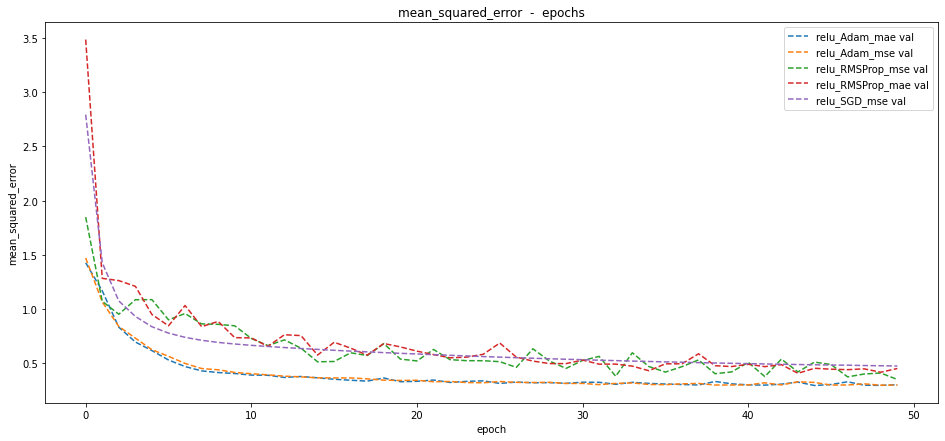

In [18]:
plot_best_per_metric('mean_squared_error')

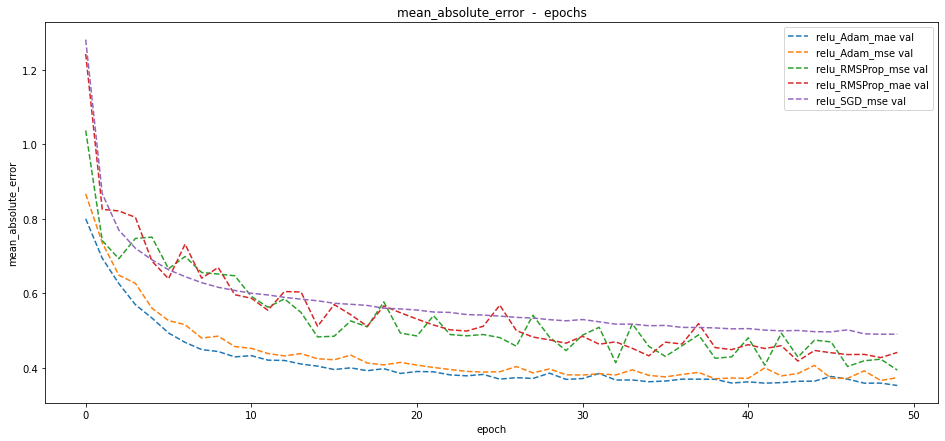

In [19]:
plot_best_per_metric('mean_absolute_error')

Посмотрим на распределение ошибок.

In [26]:
model = get_model('relu', 'Adam', 'mae')
train_history, train_logs, test_logs = train_model(model)
test_pred = model.predict(X_test).flatten()

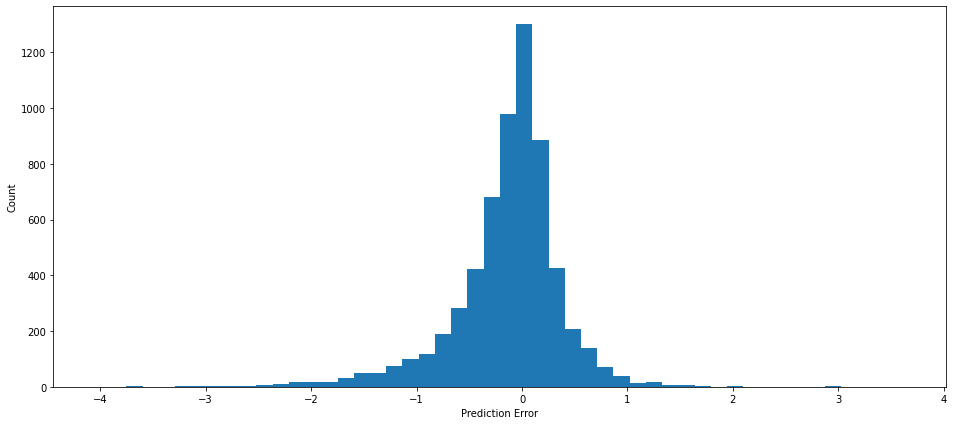

In [28]:
error = test_pred - y_test
plt.figure(figsize=(16,7))
plt.hist(error, bins=50)
plt.xlabel('Prediction Error')
plt.ylabel('Count')
plt.show()

Большая часть ошибок сконцентрирована у нуля. Модель обучилась достаточно хорошо